In [2]:
from __future__ import absolute_import
from __future__ import print_function
from tqdm import tqdm
#image are imported with a resizing and a black and white conversion
from PIL import Image
from pandas import read_csv
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pickle
import numpy as np
from imagehash import phash
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


#Change DIR to the location of the dataset
DIR = "/work/t-jachen/.kaggle/competitions/whale-categorization-playground"
tagged = dict([(p,w) for _,p,w in read_csv(DIR + '/train.csv').to_records()])
submit = [p for _,p,_ in read_csv(DIR + '/sample_submission.csv').to_records()]
join   = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]

from subprocess import check_output
print(check_output(["ls", DIR]).decode("utf8"))

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import History

import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils import plot_model
from keras.layers import Dot

from tqdm import tqdm

import sys
old_stderr = sys.stderr
sys.stderr = open('/dev/null', 'w')
import keras
sys.stderr = old_stderr

import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform

from keras.optimizers import SGD
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint

from scipy.ndimage import gaussian_filter

from keras.optimizers import Adam

SIZE = 341

bounding-box.pickle.zip
sample_submission.csv
test
test.zip
train
train.csv
train.zip



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#p = '00a29f63.jpg'
#imgs = [pil_image.open(expand_path(p)), read_raw_image(p)]
#show_whale(imgs, per_row=1)

In [53]:
tagged_list = list(tagged)

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [4]:
def expand_path(p):
    if isfile(DIR + '/train/' + p): return DIR + '/train/' + p
    if isfile(DIR + '/test/' + p): return DIR + '/test/' + p
    return p

def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    if p in rotate: img = img.rotate(180)
    return img

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


(25460,
 [('8dca9d64.jpg', (1050, 202)),
  ('beb356e1.jpg', (1050, 600)),
  ('e46fdeae.jpg', (1050, 450)),
  ('b85612eb.jpg', (1050, 525)),
  ('03acc8bc.jpg', (1050, 298))])

In [6]:
# Determise the size of each image
p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

#Rotate upside down tails
with open('./preprocessing_files/rotate.txt', 'rt') as f: rotate = f.read().split('\n')[:-1]
rotate = set(rotate)
rotate

{'2b792814.jpg',
 '2bc459eb.jpg',
 '3401bafe.jpg',
 '56fafc52.jpg',
 'a492ab72.jpg',
 'd1502267.jpg',
 'e53d2b96.jpg',
 'ed4f0cd5.jpg',
 'f2ec136c.jpg'}

In [9]:
# Read or generate p2h, a dictionary of image name to image id (picture to hash)


# Two phash values are considered duplicate if, for all associated image pairs:
# 1) They have the same mode and size;
# 2) After normalizing the pixel to zero mean and variance 1.0, the mean square error does not exceed 0.1
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 = read_raw_image(p1)
            i2 = read_raw_image(p2)
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('./preprocessing_files/p2h.pickle'):
    with open('./preprocessing_files/p2h.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h

    # Find all images associated with a given phash value.
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())
    
    # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h

len(p2h), list(p2h.items())[:5]

(25460,
 [('8dca9d64.jpg', 'acd5d7a3e0a0a59c'),
  ('beb356e1.jpg', 'bccbc3340dca72b1'),
  ('e46fdeae.jpg', 'bfc0d2b52d280f4b'),
  ('b85612eb.jpg', 'b3ceccb1a34cf08c'),
  ('03acc8bc.jpg', 'fad1b42bc83bc232')])

In [10]:
# For each image id, determine the list of pictures
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
len(h2ps),list(h2ps.items())[:5]

(20913,
 [('a9de2669966259b4', ['ce4c721f.jpg']),
  ('b1456c09c7b3f0b6', ['cdbec596.jpg']),
  ('a94697f4f91a2499', ['fa2f0694.jpg']),
  ('8fc0f53588fb2a4a', ['4b910022.jpg']),
  ('d6c9b38e91250e73', ['3fa94ac0.jpg'])])

In [11]:
# For each images id, select the prefered image
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): h2p[h] = prefer(ps)
len(h2p),list(h2p.items())[:5]

(20913,
 [('f89f8661781e87a1', 'bb1cdf9f.jpg'),
  ('b9ca8470bc3d8bc6', '05b23512.jpg'),
  ('a94697f4f91a2499', 'fa2f0694.jpg'),
  ('8fc0f53588fb2a4a', '4b910022.jpg'),
  ('b24cdf376409af42', 'b99046c7.jpg')])

In [17]:
# Read the bounding box data from the bounding box kernel (see reference above)
with open('./preprocessing_files/bounding-box.pickle', 'rb') as f:
    p2bb = pickle.load(f)
list(p2bb.items())[:5]

[('8dca9d64.jpg', (0, 0, 1039, 199)),
 ('beb356e1.jpg', (52, 188, 956, 438)),
 ('e46fdeae.jpg', (0, 52, 1037, 355)),
 ('b85612eb.jpg', (27, 157, 1025, 363)),
 ('03acc8bc.jpg', (15, 9, 1035, 275))]

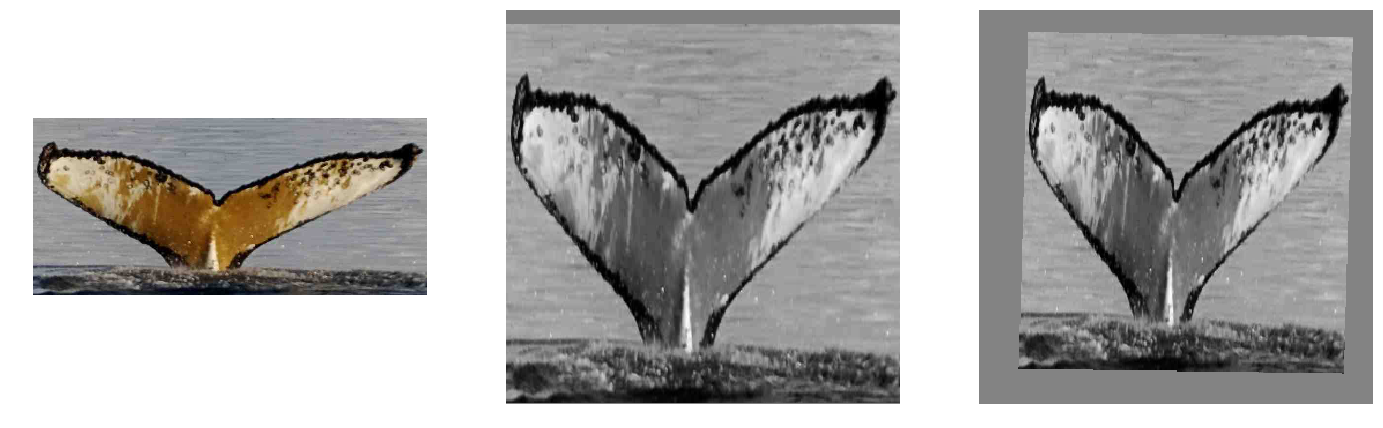

In [18]:
img_shape    = (SIZE,SIZE,1) # The image shape used by the model
anisotropy   = 2.15 # The horizontal compression ratio
crop_margin  = 0.05 # The margin added around the bounding box to compensate for bounding box inaccuracy

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    Build a transformation matrix with the specified characteristics.
    """
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # If an image id was given, convert to filename
    if p in h2p: p = h2p[p]
    size_x,size_y = p2size[p]
    
    # Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb[p]
    if p in rotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx

    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05*(y1 - y0), 0.05*(y1 - y0)),
            random.uniform(-0.05*(x1 - x0), 0.05*(x1 - x0))
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and comvert to numpy array
    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)
    
    # Apply affine transformation
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)

def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)

p = list(tagged.keys())[3]
imgs = [
    read_raw_image(p),
    array_to_img(read_for_validation(p)),
    array_to_img(read_for_training(p))
]
show_whale(imgs, per_row=3)

In [22]:
with open('./preprocessing_files/exclude.txt', 'rt') as f: exclude = f.read().split('\n')[:-1]   

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [23]:
# Find all the whales associated with an image id. It can be ambiguous as duplicate images may have different whale ids.
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

8412

In [24]:
h2ws_unamb = {}
for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous pictures
        if h2p[h] in exclude:
            print(h) # Skip excluded images
        else:
            h2ws_unamb[h] = ws[0]

In [25]:
preSplitArray = []
for key, value in h2ws_unamb.items():
    entry = []
    entry.append(key)
    entry.append(value)
    preSplitArray.append(entry)
np.random.shuffle(preSplitArray)

trainArray = preSplitArray[:7000]
testArray = preSplitArray[7000:]

trainArray = np.array(trainArray)
testArray = np.array(testArray)
train_dict = dict(zip(trainArray[:, 0], trainArray[:, 1]))
test_dict = dict(zip(testArray[:, 0], testArray[:, 1] ))
len(train_dict)

7000

In [93]:
def createSet(train_dict):
    # For each whale, find the unambiguous images ids.
    w2hs = {}
    
    for h,ws in train_dict.items():
        w = ws
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
        
 
    for w,hs in w2hs.items():
        if len(hs) > 1:
            w2hs[w] = sorted(hs)

    # Find the list of training images, keep only whales with at least two images.
    train = [] # A list of training image ids
    singles = []
    for hs in w2hs.values():
        if len(hs) > 1:
            train += hs
        else:
            singles += hs
    random.shuffle(train)
    random.shuffle(singles)
    train_set = set(train)
    singles_set = set(singles)

    w2ts = {} # Associate the image ids from train to each whale id.
    single_w2ts = {}
    for w,hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
            if h in singles_set:
                if w not in single_w2ts: single_w2ts[w] = []
                if h not in single_w2ts[w]: single_w2ts[w].append(h)
    for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
    for w,ts in single_w2ts.items(): single_w2ts[w] = np.array(ts)
    
    t2i = {} # The position in train of each training image id
    for i,t in enumerate(train): t2i[t] = i
    single_t2i = {}
    for i,t in enumerate(singles): t2i[t] = i
        
    len(train),len(w2ts)
    #w2ts has whale ID's mapped to hashes of images
    
    train_data = []
    for key, value in w2ts.items():
        train_data.append(value)
    
    single_train_data = []
    for key, value in single_w2ts.items():
        single_train_data.append(value)
    
    return train_data, single_train_data

In [95]:
train_data, single_train_data = createSet(train_dict)
test_data, single_test_data = createSet(test_dict)

(1531, 157, 2281)

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [149]:
def create_pairs(x, multWhaleArray, singleWhaleArray):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    hash_pairs = []
    pairs = []
    labels = []
    numClasses = len(multWhaleArray)
    numClassesWSingle = len(multWhaleArray) + len(singleWhaleArray)
    for i in (range(len(multWhaleArray))):
        for j in (range (len(multWhaleArray[i]))):
            #Anchor
            z1 = multWhaleArray[i][j]
        
            #Positive Pair
            if(len(multWhaleArray[i]) <= 2) :
                num = (j + 1) % 2;
            else :
                inc = random.randrange(1, len(multWhaleArray[i]) )
                num = (j + inc) % len(multWhaleArray[i])
            z2 = multWhaleArray[i][num]
            pairs += [[x[z1], x[z2]]]
            hash_pairs += [[z1, z2]]
    
            #Negative Pair
            inc = random.randrange(1, numClassesWSingle)
            dn = (i + inc) % numClassesWSingle
            
            if(dn>(len(multWhaleArray)-1)):
                dn = dn-len(multWhaleArray)
                if(len(singleWhaleArray[dn]) <= 2) :
                    num = 1;
                else :
                    num = random.randrange(1, len(singleWhaleArray[dn])-1)
                z2 = singleWhaleArray[dn][0]#[num]
                
            else: 
                if(len(multWhaleArray[dn]) <= 2) :
                    num = 1;
                else :
                    num = random.randrange(1, len(multWhaleArray[dn])-1)
                z2 = multWhaleArray[dn][num]
               
                
            pairs += [[x[z1], x[z2]]]
            hash_pairs += [[z1, z2]]
        
            labels += [1, 0]
        
    return np.array(pairs), np.array(labels), np.array(hash_pairs)

In [150]:
pairs, labels, hash_pairs = create_pairs(h2p, train_data, single_train_data)
t_pairs, t_labels, t_hash_pairs = create_pairs(h2p, test_data, single_test_data)

In [152]:
def ImportImage(filename):
    img = Image.open(filename).convert("RGB").resize((SIZE,SIZE))
    x = np.array(img)
    return x

def ImagePairsToArray(pairs, validation):
    image_pairs = []
    for i in tqdm_notebook(range(len(pairs))):
        pair = []
        if validation: 
            pair.append((read_for_validation(pairs[i][0])))
            pair.append((read_for_validation(pairs[i][1])))
        else:
            pair.append((read_for_training(pairs[i][0])))
            pair.append((read_for_training(pairs[i][1])))
        #pair.append(ImportImage(expand_path(pairs[i][0])))
        #pair.append(ImportImage(expand_path(pairs[i][1])))
        image_pairs.append(pair)
    return np.array(image_pairs)

image_pairs = ImagePairsToArray(pairs, False)
test_image_pairs = ImagePairsToArray(t_pairs, True)

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


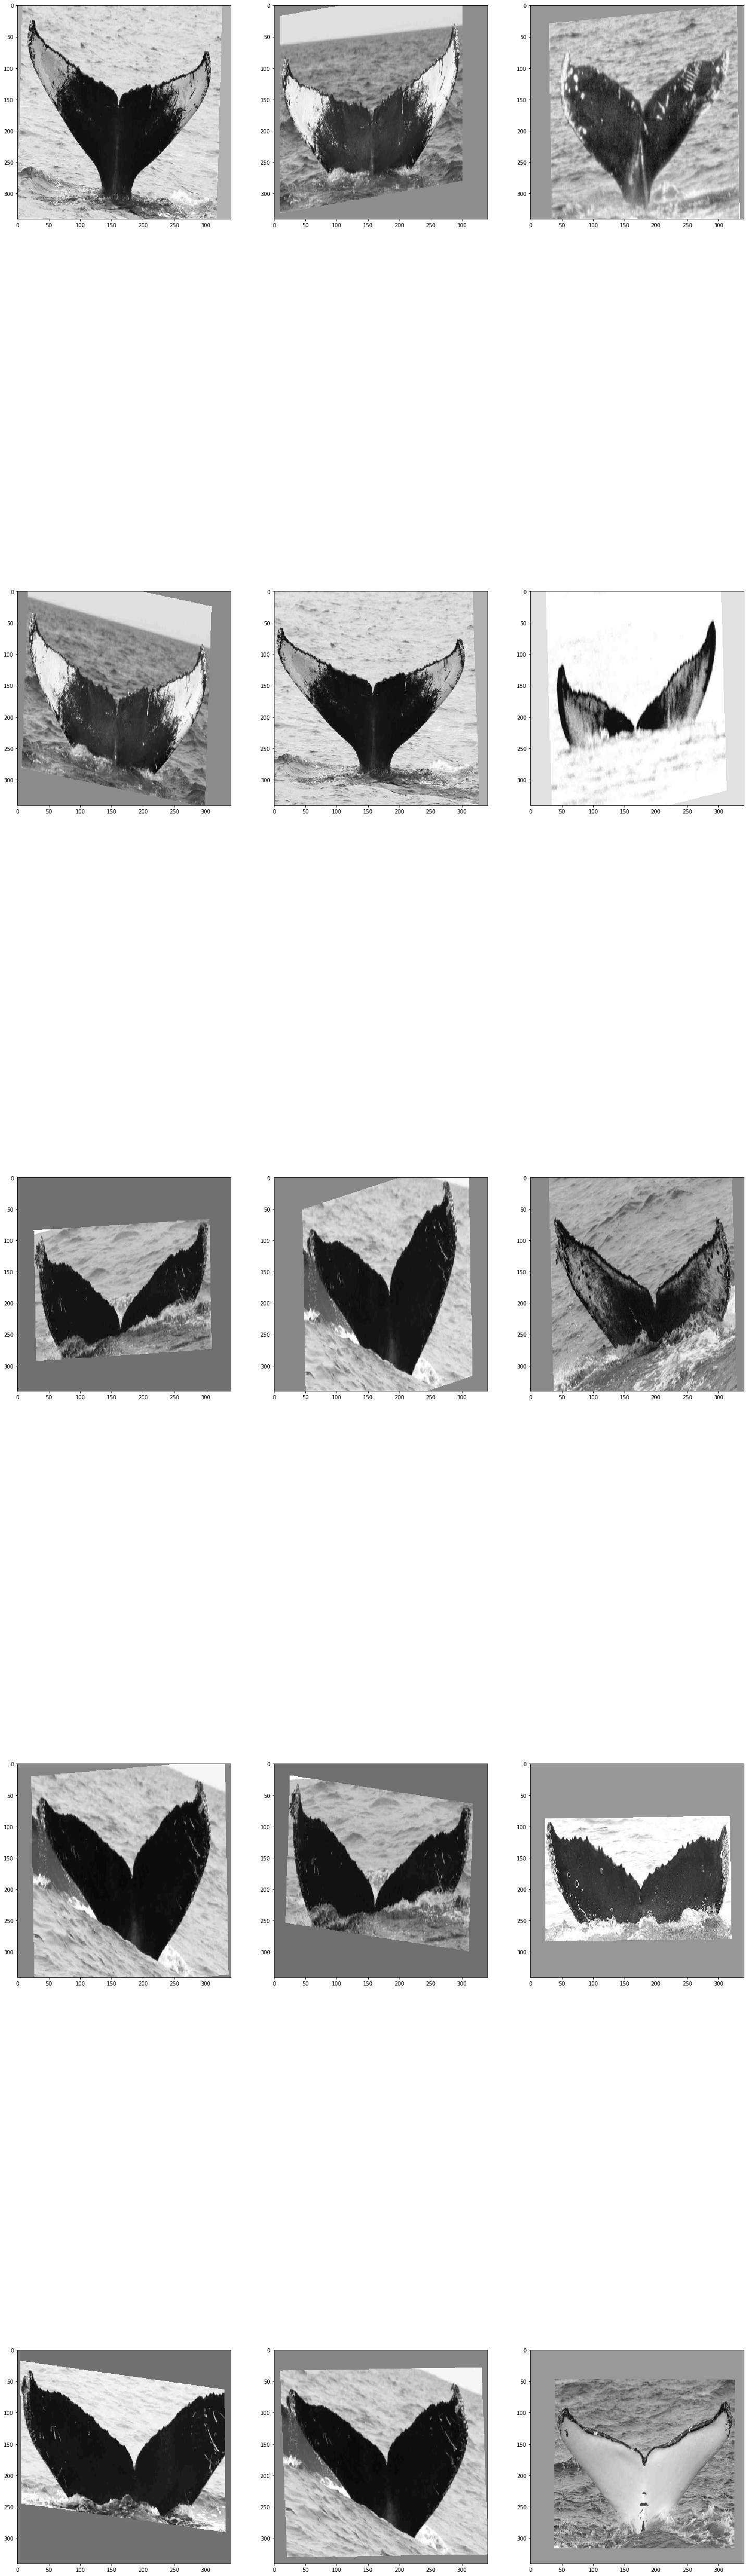

In [153]:
nTriplets = 5
plt.figure(figsize=(25,100))

from keras.preprocessing.image import img_to_array,array_to_img
# grid of 3x3 images
for i in tqdm_notebook(range(0, nTriplets)):
    plt.subplot(nTriplets, 3, 1 + i*3)
    plt.imshow(array_to_img(image_pairs[i*2, 0]))
    plt.subplot(nTriplets, 3, 2 + i*3)
    plt.imshow(array_to_img(image_pairs[i*2, 1]))
    plt.subplot(nTriplets, 3, 3 + i*3)
    plt.imshow(array_to_img(image_pairs[i*2+1, 1]))
plt.show()

In [ ]:
#Save arrys to files for future use
DIR2 = './saved_arrays'

np.save(DIR2 + '/image_pairs.npy', image_pairs)
np.save(DIR2 +'/labels.npy', labels)
np.save(DIR2 +'/test_image_pairs.npy', test_image_pairs)
np.save(DIR2 +'/t_labels.npy', t_labels)

In [ ]:
#Load arrays
if isfile(DIR+'image_pairs.npy') and isfile(DIR+'labels.npy') and isfile(DIR+'test_image_pairs.npy') and isfile(DIR+'t_labels.npy'):
    image_pairs = np.load(DIR2+'image_pairs.npy')
    labels = np.load(DIR2+'labels.npy')
    test_image_pairs = np.load(DIR2+'test_image_pairs.npy')
    t_labels = np.load(DIR2+'t_labels.npy')

In [154]:
def euclidean_distance(vects):
    x, y = vects
    print(vects)
    print(K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon())))
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    print(shape1[0], 1)
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    print(y_pred)
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    print(pred[0:100])
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [155]:
#Pretrained Model, using VGG19. Tested but low accuracy/doesn't learn.
def create_pretrained_network(input_shape):
    base_model = keras.applications.vgg19.VGG19(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = True
    #base_model.layers[-2].trainable = True
    fc1 = base_model.layers[-3]
    fc2 = base_model.layers[-2]
    predictions = base_model.layers[-1]
    
    dropout1 = Dropout(0.25)
    dropout2 = Dropout(0.25)
    
    #x = dropout1(fc1.output)
    #x = fc2(x)
    #x = dropout2(x)
    #x = predictions(x)
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(128, activation="softmax")(x)
    x = Dropout(0.25)(x)
    model = Model(base_model.input, x)
    
    model.summary()
    return model

In [4]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model

def subblock(x, filter, **kwargs):
    #x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
    #y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
    #y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

def branch_network(lr, l2, input_shape):
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=input_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    #x = Dropout(0.25)(x)
    for _ in range(2):
        #x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    #x = Dropout(0.25)(x)
  #  x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    #x = Dropout(0.25)(x)
  #  x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    #x = Dropout(0.25)(x)
  #  x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    #x = Dropout(0.25)(x)
    #x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)
    
    branch_model.summary()
    return branch_model

In [5]:
# network definition
input_shape = (SIZE, SIZE, 1)
base_network = branch_network(64e-5, 0, input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 341, 341, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 171, 171, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 85, 85, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 85, 85, 64)   36928       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_3 (

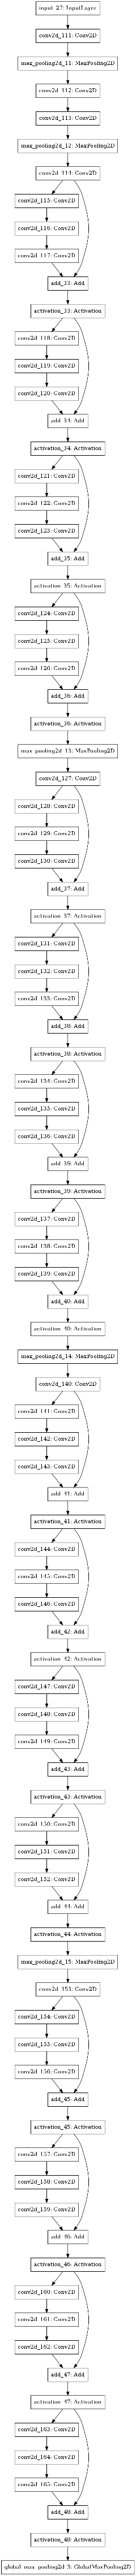

In [158]:
plot_model(base_network, to_file='./branch-model.png')
img = pil_image.open('branch-model.png')
img.resize([x//2 for x in img.size])

In [6]:
#Save base_network to be used by KNN-classifier
#base_network.load_weights('./whale_tail_weights/weights1.hdf5', by_name=True)
#base_network.save('./whale_tail_weights/base_model.h5')

In [160]:
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

In [232]:
#Euclidean Distance
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

#Cosine Distance 
distance = Dot(1, True)([processed_a, processed_b])
distance = Lambda(lambda x: 1 - x[0],output_shape=([1]))([distance])

model = Model([input_a, input_b], distance)

model.summary()

[<tf.Tensor 'model_16/global_max_pooling2d_3/Max:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'model_16_1/global_max_pooling2d_3/Max:0' shape=(?, 512) dtype=float32>]
Tensor("lambda_68/Sqrt:0", shape=(?, 1), dtype=float32)
None 1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 341, 341, 1)  0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 341, 341, 1)  0                                            
__________________________________________________________________________________________________
model_16 (Model)                (None, 512)          2656512     input_28[0][0]                   
                                                                 input_29[0][

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [236]:
model.load_weights('./whale_tail_weights/weights_euclidean.hdf5', by_name=True)
#model.load_weights('./whale_tail_weights/weights_cosine.hdf5', by_name=True)

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [233]:
# Optimizer. SGD had the best results
sgd = SGD(lr = 0.001, decay=1e-6, momentum=0.9, nesterov=True)
#rms = RMSprop(lr=0.1)
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#Checkpointer saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath='./whale_tail_weights/weights_checkpointer.hdf5', verbose=1, save_best_only=True)

model.compile(loss=contrastive_loss, optimizer=adam, metrics=[accuracy])

Tensor("lambda_69/sub:0", shape=(?, 1), dtype=float32)


In [234]:
history = model.fit([image_pairs[:, 0], image_pairs[:, 1]], labels,
          batch_size=32, #validation_split = 0.289,
          validation_data = ([test_image_pairs[:, 0], test_image_pairs[:, 1]], t_labels),
          epochs=30, initial_epoch = 0, shuffle = True, callbacks=[checkpointer])

Train on 9438 samples, validate on 740 samples
Epoch 1/30


/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


9438/9438 [==============================] - 193s 20ms/step - loss: 0.2186 - accuracy: 0.6811 - val_loss: 0.1633 - val_accuracy: 0.7703

Epoch 00001: val_loss improved from inf to 0.16327, saving model to ./whale_tail_weights/weights4.hdf5
Epoch 2/30
9438/9438 [==============================] - 186s 20ms/step - loss: 0.1750 - accuracy: 0.7489 - val_loss: 0.1659 - val_accuracy: 0.7662

Epoch 00002: val_loss did not improve from 0.16327
Epoch 3/30
9438/9438 [==============================] - 186s 20ms/step - loss: 0.1631 - accuracy: 0.7682 - val_loss: 0.1673 - val_accuracy: 0.7527

Epoch 00003: val_loss did not improve from 0.16327
Epoch 4/30
9438/9438 [==============================] - 186s 20ms/step - loss: 0.1550 - accuracy: 0.7788 - val_loss: 0.1461 - val_accuracy: 0.7892

Epoch 00004: val_loss improved from 0.16327 to 0.14611, saving model to ./whale_tail_weights/weights4.hdf5
Epoch 5/30
9438/9438 [==============================] - 186s 20ms/step - loss: 0.1495 - accuracy: 0.7885 - 

KeyboardInterrupt: 

In [238]:
model.save('./whale_tail_weights/model.h5')

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [237]:
model.save_weights('./whale_tail_weights/weights_euclidean.hdf5')
#model.save_weights('./whale_tail_weights/weights_cosine.hdf5')

dict_keys(['val_loss', 'loss', 'val_accuracy', 'accuracy'])


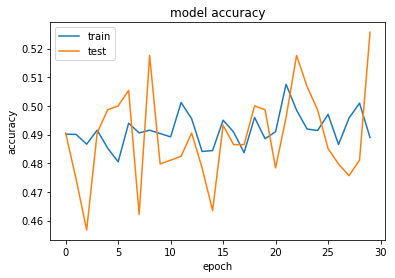

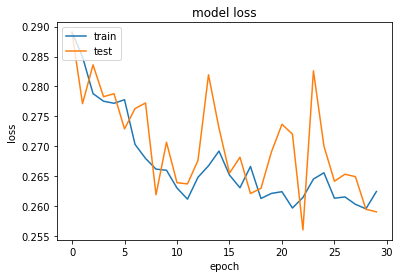

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [83]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
tr_pred = model.predict([image_pairs[:, 0], image_pairs[:, 1]], verbose = 1)
tr_acc = compute_accuracy(labels, tr_pred)
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print(tr_pred[0:100])


9520/9520 [==============================] - 66s 7ms/step
[ True False  True False False False False False  True  True  True False
  True False  True False  True False  True False  True  True  True  True
  True False  True False False  True  True  True  True  True  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True  True  True  True  True False
  True False  True False  True False  True False False  True False  True
  True  True  True  True  True  True  True False  True False  True False
  True  True  True False  True  True  True  True False False  True  True
 False False  True False]
* Accuracy on training set: 77.99%
[[0.21744645]
 [1.3698161 ]
 [0.15546712]
 [1.1118953 ]
 [0.5710367 ]
 [0.8324978 ]
 [0.5232412 ]
 [0.8519935 ]
 [0.31600156]
 [0.44128168]
 [0.28222156]
 [1.0036368 ]
 [0.20615986]
 [0.9450336 ]
 [0.17671809]
 [0.7069681 ]
 [0.11504892]
 [1.0346309 ]
 [0.36831358]
 [0.96384907]
 [0.36063203]
 [0

In [73]:
te_pred = model.predict([test_image_pairs[:, 0], test_image_pairs[:, 1]], verbose = 1)
te_acc = compute_accuracy(t_labels, te_pred)
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))
print(te_pred[0:100])

738/738 [==============================] - 5s 7ms/step
[ True  True  True False  True  True  True  True  True False  True False
  True False  True False  True False  True False  True  True  True  True
  True False  True  True  True False  True  True  True  True  True False
  True False  True  True  True  True  True False  True False  True False
  True False  True False  True  True  True False  True False  True False
  True False  True  True False  True False False  True False  True  True
  True False  True False  True False  True False  True False  True False
  True False  True  True  True  True  True  True  True False  True False
  True False  True  True]
* Accuracy on test set: 77.64%
[[0.20399672]
 [0.167604  ]
 [0.20399672]
 [0.7940804 ]
 [0.2535829 ]
 [0.20455688]
 [0.2535829 ]
 [0.32105494]
 [0.32417092]
 [0.60621053]
 [0.32417092]
 [0.69474024]
 [0.14494771]
 [0.8371932 ]
 [0.14494771]
 [0.6631824 ]
 [0.2733489 ]
 [1.1020278 ]
 [0.2733489 ]
 [0.82320267]
 [0.27568397]
 [0.222583

In [70]:
#Find the indexes of whale pairs that the model incorrectly predicted
def compare_labels(p_labels, true_labels):
    pred = p_labels.ravel() < 0.5
    int_labels = []
    for i in pred:
        if(i):
            int_labels.append(1)
        else:
            int_labels.append(0)
    
    diff_indexes = []
    for i in range(len(int_labels)):
        if(int_labels[i] != true_labels[i]):
            diff_indexes.append(i)
    return diff_indexes

diff_training = (compare_labels(tr_pred, labels))
diff_test = (compare_labels(te_pred, t_labels))
print(diff_training)
print(diff_test)

[1, 17, 19, 23, 25, 28, 33, 35, 41, 42, 47, 59, 63, 64, 71, 73, 74, 77, 82, 83, 84, 85, 99, 101, 107, 110, 114, 116, 120, 144, 159, 160, 163, 171, 174, 175, 177, 182, 189, 190, 192, 206, 208, 213, 220, 222, 223, 229, 230, 233, 235, 236, 239, 240, 243, 255, 256, 257, 262, 264, 265, 269, 270, 271, 272, 273, 278, 287, 289, 293, 299, 301, 311, 313, 319, 323, 325, 335, 337, 339, 343, 352, 354, 357, 362, 364, 366, 370, 371, 372, 376, 377, 379, 383, 385, 387, 393, 397, 400, 402, 415, 434, 437, 438, 440, 441, 442, 443, 445, 446, 449, 452, 454, 459, 461, 463, 465, 466, 469, 471, 478, 479, 480, 483, 491, 493, 499, 503, 509, 515, 519, 525, 530, 533, 537, 541, 545, 547, 551, 555, 565, 571, 581, 592, 599, 609, 612, 619, 623, 626, 627, 631, 649, 659, 661, 665, 669, 671, 675, 683, 700, 707, 721, 723, 725, 730, 733, 739, 742, 743, 747, 755, 772, 777, 780, 781, 787, 789, 799, 801, 802, 805, 816, 818, 821, 822, 824, 825, 829, 832, 835, 837, 838, 839, 841, 844, 847, 849, 851, 853, 874, 876, 885, 893, 897

In [71]:
#For whales pairs that were incorrectly predicted, determine how many were matching pairs and how many were non-matching pairs
matching = 0
notmatching = 0
for i in diff_test:
    if (i%2 == 0):
        matching = matching +1
    else:
        notmatching = notmatching + 1
matching, notmatching

(51, 139)

True label: Different Whales
Predicted label: Same Whale [0.44128168]


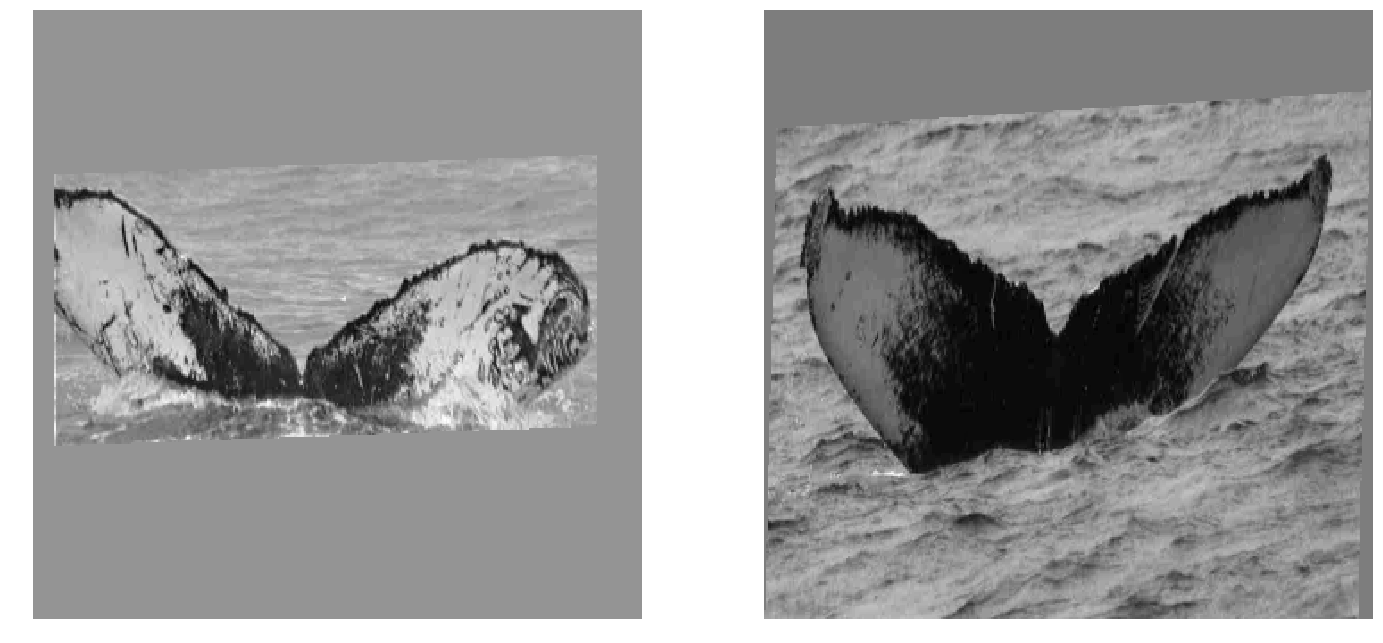

In [35]:
def show_pair(index, images, p_labels, true_labels):
    print("True label:", end= " ")
    if(true_labels[index] == 1):
        print("Same Whale")
    else:
        print("Different Whales")
        
    print("Predicted label:", end=" ")
    if(p_labels[index] < 0.5):
        print("Same Whale", p_labels[index])
    else:
        print("Different Whales", p_labels[index])
    imgs = [
        array_to_img(images[index,0]),
        array_to_img(images[index,1])
    ]
    show_whale(imgs, per_row=2)
show_pair(9, image_pairs, tr_pred, labels)